# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

### 🚨 WARNING
The notebook will not run unless all simulations have been stored in the `output`folder.

_Note_: a `figures` folder will be created in which the tables are saved.

Simulations can be run using the following command:
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --aug-strategy-train augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10

```

📝 Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

### Goal

The aim of this notebook is to compare the results on the test set for
- all tasks (ESOL, FreeSolv, and lipophilicity),
- all models (CONV1D, CONV2D and RNN),
- all augmentation strategies: no augmentation, augmentation with-, without-, with reduced duplication, and estimated maximum,

and analyse the results.

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from maxsmi.utils_analysis import retrieve_metric

In [2]:
# Path to this notebook
HERE = Path(_dh[-1])

In [3]:
path_to_output = HERE.parents[0]

In [4]:
# Make a folder for output figures
os.makedirs(f"{HERE}/figures", exist_ok=True)

## Plots

Let's plots these results.

#### Grid: augmentation number

The models were run of a fine grid augmentation: from 1 to 20 with a step of 1 as well as a coarser grid: from 20 to 100 with a step of 10.

In [5]:
fine_grid = [elem for elem in range(1, 21, 1)]
coarse_grid = [elem for elem in range(10, 110, 10)]

temp_grid = [elem for elem in range(30, 110, 10)]
full_grid = fine_grid + temp_grid

### Plot for best model
Which model performs best?

In [6]:
def plot_metric_for_model(metric,
                          set_,
                          augmentation_strategy,
                          task="ESOL",
                          grid=full_grid):
    """
    Plots the metric of interest on the set of interest for a given model.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    augmentation_strategy : str
            The augmentation strategy used.
    task : str
        The task considered.
    grid : list
        The grid to retrieve for aumgentation number.

    Returns
    -------
    None
    """
    models = ["CONV1D", "CONV2D", "RNN"]

    x = [step for step in grid]

    fig, ax = plt.subplots(1, 1)

    for model in models:
        legend_ = []
        y_model = []
        for augmentation_num in grid:
            y = retrieve_metric(
                path_to_output,
                metric,
                set_,
                task,
                augmentation_strategy,
                augmentation_num,
                augmentation_strategy,
                augmentation_num,
                model,
            )
            y_model.append(y)
        ax.plot(x, y_model)
        ax.set_title(f"Data: {task} \nStrategy: {augmentation_strategy}")
        ax.set_xlabel("Number of augmentation")
        ax.set_xlabel("Number of augmentation")
        if metric == "rmse":
            ax.set_ylabel(f"RMSE ({set_})")
        elif metric == "time":
            ax.set_ylabel(f"{metric} ({set_}) [sec]")
        else:
            ax.set_ylabel(f"{metric} ({set_})")
        legend_.append(model)
    ax.legend(models)

    plt.savefig(f"figures/{task}_best_ml_model.png",
                dpi=1200,
                facecolor='w',
                edgecolor='w',
                orientation='portrait',
                format="png",
                transparent=False,
                bbox_inches=None,
                pad_inches=0.1,)

    plt.show()

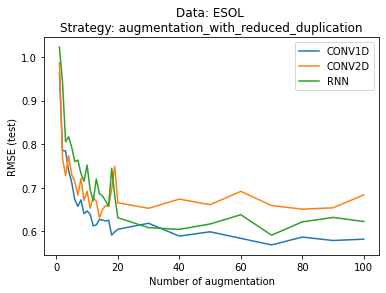

In [7]:
plot_metric_for_model("rmse", "test",
                      "augmentation_with_reduced_duplication",
                      grid=full_grid)

### Plot for best strategy
Which strategy performs best?

In [8]:
def plot_metric_for_strategy(metric,
                             set_,
                             task="ESOL",
                             model="CONV1D",
                             grid=full_grid):
    """
    Plots the metric of interest on the set of interest
    for a given model.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    task : str
        The task of interest, e.g. "ESOL".
    model : str
        The model to consider.
    grid : list
        The grid to retrieve for aumgentation number.

    Returns
    -------
    None
    """

    x = [step for step in grid]

    fig, ax = plt.subplots(1, 1)

    for augmentation_strategy in [
        "augmentation_with_duplication",
        "augmentation_without_duplication",
        "augmentation_with_reduced_duplication"
    ]:
        legend_ = []
        y_strategy = []
        for augmentation_num in grid:
            y = retrieve_metric(
                path_to_output,
                metric,
                set_,
                task,
                augmentation_strategy,
                augmentation_num,
                augmentation_strategy,
                augmentation_num,
                model,
            )
            y_strategy.append(y)
        ax.plot(x, y_strategy)
        if metric == "rmse":
            ax.set_ylabel(f"RMSE ({set_})")
        elif metric == "time":
            ax.set_ylabel(f"{metric} ({set_}) [sec]")
        else:
            ax.set_ylabel(f"{metric} ({set_})")
        legend_.append(augmentation_strategy)

    ax.set_title(f"Data: {task}\nModel: {model}")
    ax.set_xlabel("Number of augmentation")

    # Retrieve no augmentation
    y_no_augmentation = retrieve_metric(
        path_to_output,
        metric,
        set_,
        task,
        "no_augmentation",
        0,
        "no_augmentation",
        0,
        model,
    )
    # Retrieve augmentation with maximum duplication
    if task == "ESOL":
        task = "ESOL_small"
    y_est_max = retrieve_metric(
        path_to_output,
        metric,
        set_,
        task,
        "augmentation_maximum_estimation",
        10,
        "augmentation_maximum_estimation",
        10,
        model,
    )
    if task == "ESOL_small":
        task = "ESOL"
    plt.axhline(y=y_est_max, color='r', linestyle='-')
    trans = transforms.blended_transform_factory(
        ax.get_yticklabels()[0].get_transform(),
        ax.transData)
    ax.text(0, y_est_max,
            f"{y_est_max:.3f}",
            transform=trans,
            color='red',
            ha="right",
            va="center")

    plt.axhline(y=y_no_augmentation,
                color='black',
                linewidth=0.7,
                linestyle='dashed')

    ax.legend([
        "augmentation_with_duplication",
        "augmentation_without_duplication",
        "augmentation_with_reduced_duplication",
        "augmentation_with_estimated_maximum",
        "no_augmentation"
        ])
    plt.savefig(f"figures/{task}_{model}_best_strategy.png",
                dpi=1200,
                facecolor='w',
                edgecolor='w',
                orientation='portrait',
                format="png",
                transparent=False,
                bbox_inches=None,
                pad_inches=0.1,)

    plt.show()

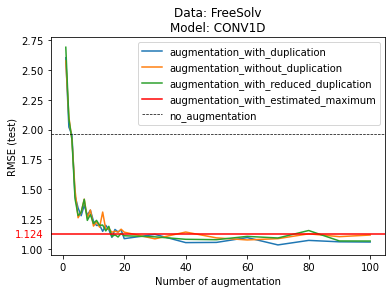

In [9]:
plot_metric_for_strategy("rmse",
                         "test",
                         task="FreeSolv",
                         model="CONV1D",
                         grid=full_grid)

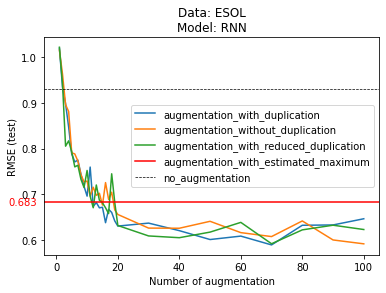

In [10]:
plot_metric_for_strategy("rmse",
                         "test",
                         task="ESOL",
                         model="RNN",
                         grid=full_grid)

### Plot all metrics, all models and all augmentation strategies

In [11]:
def plot_all(metric, set_, grid, save_fig=False):
    """
    Plots the metric of interest on the set of interest.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    augmentation_strategy : str
            The augmentation strategy used.
    max_augmentation : int, default is 100.
        The largest number of augmentation that was performed.
    save_fig : bool
        Whether to save the figure or not.

    Returns
    -------
    None
    """

    tasks = ["ESOL", "FreeSolv", "lipophilicity"]
    models = ["CONV1D", "CONV2D", "RNN"]

    x = [step for step in grid]

    fig, ax = plt.subplots(nrows=len(tasks),
                           ncols=len(models),
                           figsize=(20, 20))

    for i, task in enumerate(tasks):
        for j, model in enumerate(models):
            legend_ = []
            for augmentation_strategy in [
                "augmentation_with_duplication",
                "augmentation_without_duplication",
                "augmentation_with_reduced_duplication"
            ]:
                y_task_model_strategy = []
                for augmentation_num in grid:
                    y = retrieve_metric(
                        path_to_output,
                        metric,
                        set_,
                        task,
                        augmentation_strategy,
                        augmentation_num,
                        augmentation_strategy,
                        augmentation_num,
                        model,
                    )
                    y_task_model_strategy.append(y)
                ax[i, j].plot(x, y_task_model_strategy)
                ax[i, j].set_title(f"Data: {task} \nModel: {model}")
                ax[i, j].set_xlabel("Number of augmentation")
                if metric == "rmse":
                    ax[i, j].set_ylabel(f"RMSE ({set_})")
                elif metric == "time":
                    ax[i, j].set_ylabel(f"{metric} ({set_}) [sec]")
                else:
                    ax[i, j].set_ylabel(f"{metric} ({set_})")
                caption = f"{augmentation_strategy}"
                legend_.append(caption)
                ax[i, j].legend(legend_)
    if save_fig:
        plt.savefig(f"figures/all_combinations_{metric}_{set_}.png",
                dpi=1200,
                facecolor='w',
                edgecolor='w',
                orientation='portrait',
                format="png",
                transparent=False,
                bbox_inches=None,
                pad_inches=0.1,)
    plt.show()

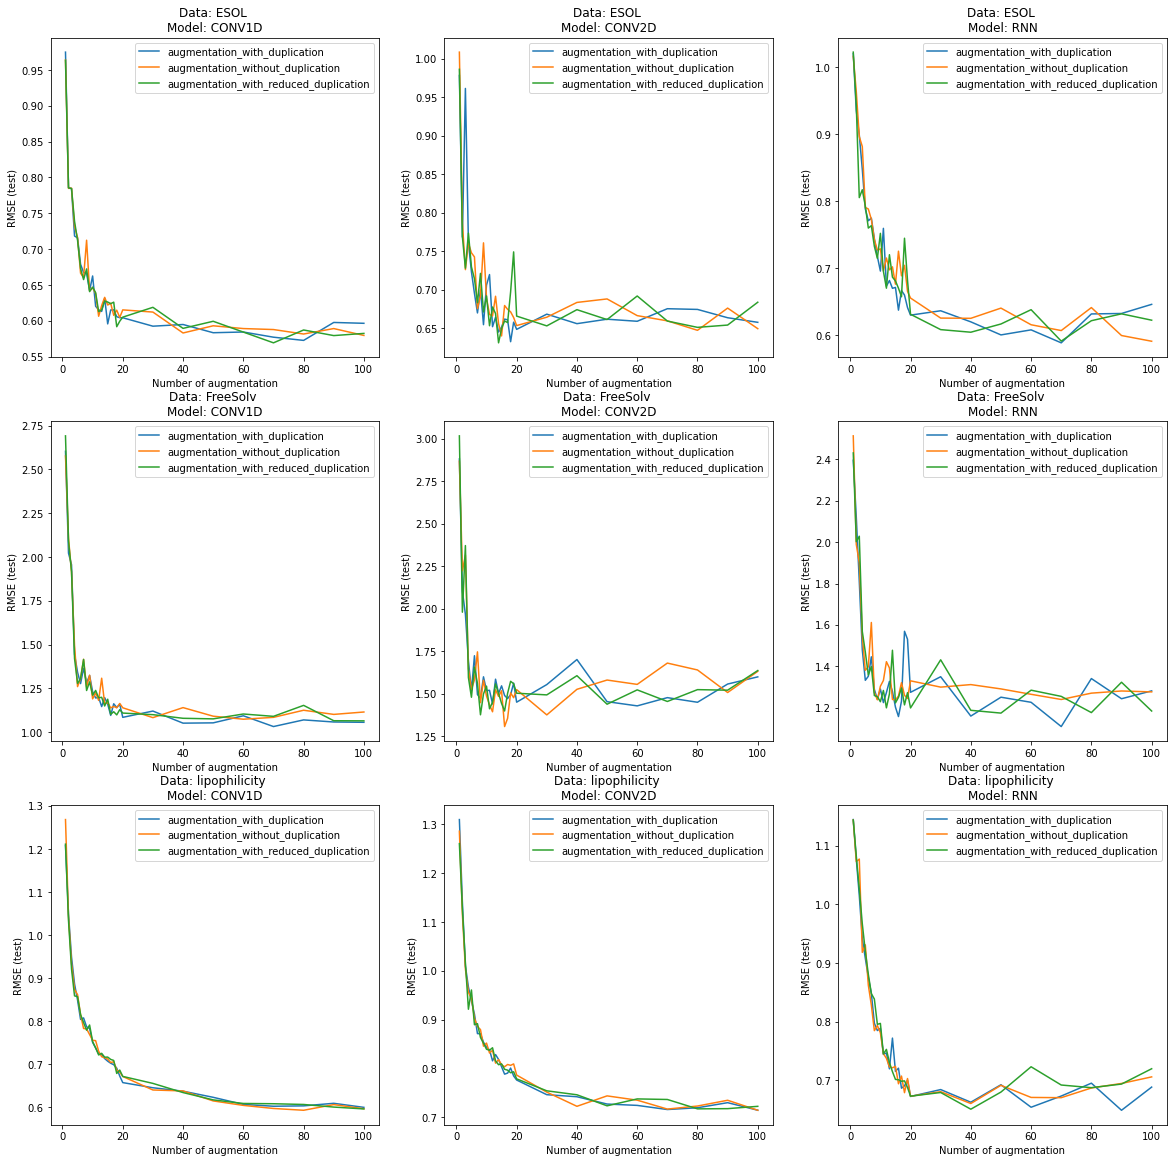

In [12]:
plot_all("rmse", "test", full_grid)

Given the plots above, we create a function to plot a single one.

In [13]:
def plot_single(metric, set_, grid, task, model):
    """
    Plots the metric of interest on the set of interest.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    task : str
        The considered task.
    model : str
        The considered model.

    Returns
    -------
    None
    """

    x = [step for step in grid]

    fig, ax = plt.subplots()

    legend_ = []
    for augmentation_strategy in [
        "augmentation_with_duplication",
        "augmentation_without_duplication",
        "augmentation_with_reduced_duplication"
    ]:
        y_task_model_strategy = []
        for augmentation_num in grid:
            y = retrieve_metric(
                path_to_output,
                metric,
                set_,
                task,
                augmentation_strategy,
                augmentation_num,
                augmentation_strategy,
                augmentation_num,
                model,
            )
            y_task_model_strategy.append(y)
        ax.plot(x, y_task_model_strategy)
        ax.set_title(f"Data: {task} \nModel: {model}")
        ax.set_xlabel("Number of augmentation")
        ax.set_ylabel(f"{metric}")
        if metric == "rmse":
            ax.set_ylabel(f"RMSE ({set_})")
        elif metric == "time":
            ax.set_ylabel(f"{metric} ({set_}) [sec]")
        else:
            ax.set_ylabel(f"{metric} ({set_})")
        caption = f"{augmentation_strategy}"
        legend_.append(caption)
        ax.legend(legend_)
    plt.savefig(f"figures/{task}_{metric}_{model}_{set_}_3strategies.png",
            dpi=1200,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format="png",
            transparent=False,
            bbox_inches=None,
            pad_inches=0.1,)
    plt.show()

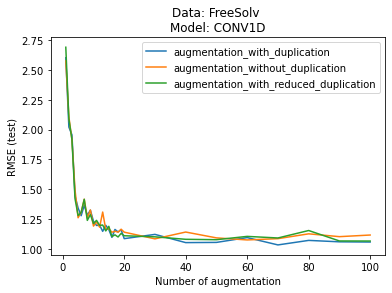

In [14]:
plot_single("rmse", "test", full_grid, "FreeSolv", "CONV1D")

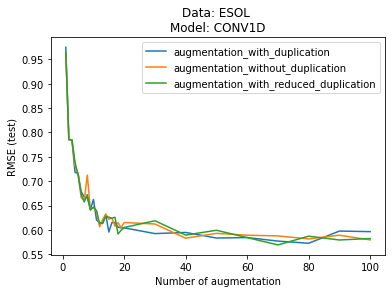

In [15]:
plot_single("rmse", "test", full_grid, "ESOL", "CONV1D")

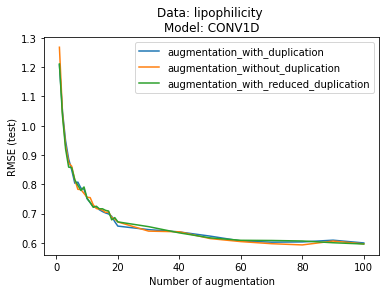

In [16]:
plot_single("rmse", "test", full_grid, "lipophilicity", "CONV1D")

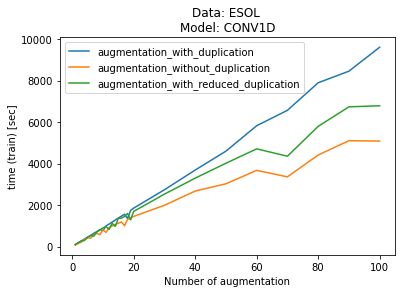

In [17]:
plot_single("time", "train", full_grid, "ESOL", "CONV1D")